In [73]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import math
from sqlalchemy import *
from collections import defaultdict
from math import sqrt

In [58]:
sns.set_style("white")
sns.set_context("paper")

def figsize(fig_width_pt=None, fig_height_pt=None):
    
    if fig_width_pt is None:
        fig_width_pt = 469.755 # Get this from LaTeX using \the\textwidth
        
    inches_per_pt = 1.0/72.27
    fig_width_pt = fig_width_pt*inches_per_pt  # Convert pt to inch

    if fig_height_pt is None:
        golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height_pt = fig_width_pt*golden_mean # height in inches
        
    fig_size = [fig_width_pt,fig_height_pt]
    return fig_size

# Exploration of the data

In [4]:
# Creating SQLAlchemy's engine to use
engine = create_engine('postgresql://nadai@localhost:5432/WWW')

In [61]:
quarters = defaultdict(list)

sql = text('SELECT i.pro_com::int, i.ace::int FROM istat_sezioni i INNER JOIN cities c ON i.pro_com = c.pro_com WHERE ace <> 0')
result = engine.execute(sql)
names = []
for r in result:
    quarters[r[0]].append(r[1])

Get the data for the considered neighborhoods

In [63]:
city_df = pd.read_csv('generated_files/computed_metrics.csv')
city_df = city_df[(city_df.ace != 0)]
city_df.head()

,ace,pro_com,LUM5_single,RNR_nres,nig_rat_daily,hType_mix,hType_mix2,hType_mix3,mdist_nres_daily,ratio_daily_nondaily,...,bld_rat_int,emp_rat_pop,emp_rat_num,bld_rat_area,bor_rat_area,mdist_parks,mdist_smallparks,mdist_railways,mdist_water,mdist_highways
0,1,82053,0.834913,0.720798,0.314583,0.907508,4.370384,2.322173,25.988807,0.377500,...,5.80078,1.437335,0.007092,0.455101,0.000000,1945.604863,221.193580,920.011375,1368.702528,2824.749650
1,5,82053,0.997769,0.896482,0.020000,0.831259,4.737226,2.303030,54.760342,0.181818,...,10.06200,1.963687,0.004797,0.298615,0.131742,2424.571583,436.532829,299.307165,604.726985,2037.927785
2,6,82053,0.671734,0.695502,0.111111,0.899967,4.065773,2.239130,101.339152,0.166667,...,9.09622,6.091624,0.002088,0.234750,0.003436,3526.516135,405.696049,428.644805,911.581690,1339.969963
3,7,82053,0.558117,0.577314,0.000000,0.970021,3.403636,1.941176,100.401111,0.000000,...,10.67450,19.883005,0.000743,0.198219,0.000000,4915.361344,959.766201,846.295364,1125.378636,1173.661382
4,8,82053,0.613831,0.499160,0.100000,0.964111,3.434889,2.130872,253.662195,0.285714,...,4.69656,6.295181,0.000897,0.175623,0.226589,3815.484344,1045.965308,190.534664,1629.066907,463.298247


In [66]:
telco_df = pd.read_csv('generated_files/telco.csv')
telco_df = telco_df[(telco_df.ace != 0)]
telco_df = telco_df[['pro_com', 'ace', 'avg_activity']]
telco_df = pd.merge(city_df[['pro_com', 'ace', 'area_filtr']], telco_df, on =['pro_com', 'ace'])
telco_df['activity_density'] = telco_df['avg_activity'] / telco_df['area_filtr']
telco_df.head()

,pro_com,ace,area_filtr,avg_activity,activity_density
0,82053,1,2.294074e+06,18949.713243,0.008260
1,82053,5,6.717292e+05,5422.352899,0.008072
2,82053,6,1.583958e+06,5692.537045,0.003594
3,82053,7,1.092818e+06,1716.446124,0.001571
4,82053,8,1.665450e+06,4024.927239,0.002417


In [13]:
city_df['num_intersect']= city_df['num_intersect']/city_df['area_filtr']
city_df['num_community_places']=city_df['num_community_places']/city_df['area_filtr']

city_df['mdist_nres_daily'] = 1./city_df['mdist_nres_daily']
city_df['mdist_parks'] = 1./city_df['mdist_parks']
city_df['mdist_smallparks'] = 1./city_df['mdist_smallparks']
city_df['mdist_railways'] = 1./city_df['mdist_railways']
city_df['mdist_highways'] = 1./city_df['mdist_highways']
city_df['mdist_water'] = 1./city_df['mdist_water']

Convenient names for the features

In [14]:
nomi_sensati = {
    'LUM5_single': 'Single use entropy',
    'RNR_nres': 'Entropy residential/non-res',
    'mdist_nres_daily': 'Mean dist. nearest daily-use POI',
    'ratio_daily_nondaily': 'Ratio non-daily - daily buildings',
    'nig_rat_daily': 'Ratio night life places and total POIs',
    'nig_rat_daily3': 'Night life places density',
    'hType_mix': 'Housing type entropy',
    'hType_mix2': '2Housing type entropy',
    'hType_mix3': '3Housing type entropy',
    
    'avg_block_area': 'Average block area',
    'rat_block_area': 'Ratio block area and total area',
    'num_intersect': 'Intersections density',
    'ratio_4ways_intersect': 'Ratio 4-way intersections',
    'mean_dist_intersect': 'Avg distance buildings inters',
    'sphi': 'anisotropicity blocks',
    'num_community_places': 'ratio third places - POIs',
    'num_community_places_poi': 'poi ratio third places - POIs',
    
    'bld_entr_age': 'Entropy build. age',
    'bld_entr_interiors': 'Entropy build. interiors',
    'enterprises_entr_size': 'Entropy enterprises size',
    'enterprises_empl_size': 'Avg employees per company',
    
    'bld_rat_int': 'ratio internal ap. and num buildings',
    'pop_rat_num': 'ratio num people and area',
    'emp_rat_num': 'Employment density',
    'emp_rat_pop': 'ratio pop density and employment density',
    'bld_rat_area': 'ratio buildings area and total area',
    
    'bor_rat_area': 'ratio vacuums area and total area',
    'mdist_parks': 'Avg distance blocks - parks',
    'mdist_smallparks': 'Avg distance blocks - small parks',
    'mdist_railways': 'Avg distance blocks - railways',
    'mdist_highways': 'Avg distance blocks - highways',
    'mdist_water': 'Avg distance blocks - water',
    
    
    
    'avg_activity': 'Average activity',
    'avg_activity_day': 'Average activity (daytime)',
    'avg_activity_night': 'Average activity (night-time)',
    'num_permanents': '# Permanent hotspots',
    'num_intermittents': '# Intermittents hotspots',
    'num_intermediates': '# Intermediates hotspots',
    'prop_permanents': '# Permanent hotspots',
    'prop_intermittents': '# Intermittents hotspots',
    'prop_intermediates': '# Intermediates hotspots',
    'activity_density': "Activity density",
    'activity_density_day': "Activity density (daytime)",
    'activity_density_night': "Activity density (night-time)",
    'prop_hotspots_night': "Num hotspots at night",
    'prop_hotspots_day': "Num hotspots at daytime",
    'iqr2': 'IQR',
    'diff':'diff',
    
    
    'den_nres_daily': 'den_nres_daily',
    'den_nres_non-daily': 'den_nres_non-daily',
    'bld_avg_age': 'bld_avg_age',
    'bld_std_age': 'bld_std_age'
}

## Correlations

In [15]:
from numbers import Number

def compute_stats(feature, corr_df, social_index, social_name, c2):
    #pearson = stats.pearsonr(social_index.values, feature.values)
    spearman = stats.spearmanr(social_index.values, feature.values)
    #corr_df.loc[social_name,('Pearson','correlation')] = pearson[0]
    #corr_df.loc[social_name,('Pearson','p-value')] = pearson[1]
    corr_df.loc[social_name,c2] = as_correlation_value(spearman[0], spearman[1])
    return corr_df

def print_stats_features(df_f_i, corr_df, social_index_i):
    df_f_i = df_f_i.sort_values(['pro_com','ace'])
    social_index_i = social_index_i.sort_values(['pro_com','ace'])
    for c in df_f_i.columns:
        if c not in {'ace', 'pro_com', 'area', 'area_filtr'}:
            for c2 in social_index_i.columns:
                if c2 not in {'ace', 'pro_com', 'area', 'area_filtr'}:
                    corr_df = compute_stats(df_f_i[c], corr_df, social_index_i[c2], nomi_sensati[c], c2)
                    
    return corr_df

def as_correlation_value(v, p_value):  
    if isinstance(v, Number):
        add = ''
        if p_value < 0.01:
            add = '**'
        elif p_value < 0.05:
            add = '*'
        return "{0:.4f}".format(v)+add
    else:
        raise TypeError("Numeric type required")


### 2-way correlations

Legend:
* "*": p-value < 0.05
* "**": p-value < 0.01

In [67]:
corr_df = pd.DataFrame({})
corr_df = print_stats_features(city_df[city_df.pro_com!=27042], corr_df, telco_df[telco_df.pro_com!=27042])
corr_df

,avg_activity,activity_density
Single use entropy,0.1548**,-0.1182*
Entropy residential/non-res,0.2689**,0.1422**
Ratio night life places and total POIs,0.2333**,0.2935**
Housing type entropy,-0.1490**,-0.6214**
2Housing type entropy,0.1958**,0.7075**
3Housing type entropy,-0.0351,-0.0907
Mean dist. nearest daily-use POI,-0.2103**,-0.8081**
Ratio non-daily - daily buildings,0.2035**,0.2549**
Night life places density,0.3448**,0.7968**
den_nres_daily,0.2646**,0.8523**


### Milano

In [69]:
some_attributes = ['pro_com', 'ace', 'hType_mix2',
 'mdist_smallparks',
 'num_community_places',
 'num_intersect',
 'pop_rat_num',
 'emp_rat_num',
 'bld_avg_age',
 'enterprises_empl_size',
 'mdist_highways']

In [70]:
corr_df = pd.DataFrame({})
corr_df = print_stats_features(city_df[city_df.pro_com==15146][some_attributes], corr_df, telco_df[telco_df.pro_com==15146])
corr_df

,avg_activity,activity_density
2Housing type entropy,0.1846,0.6062**
Avg distance blocks - small parks,0.1201,-0.1058
ratio third places - POIs,0.7070**,0.8457**
Intersections density,0.7146**,0.4356**
ratio num people and area,-0.1393,0.6094**
Employment density,0.5427**,0.8839**
bld_avg_age,0.4795**,0.7882**
Avg employees per company,0.4908**,0.0500
Avg distance blocks - highways,0.3616**,0.6280**


### Roma

In [71]:
corr_df = pd.DataFrame({})
corr_df = print_stats_features(city_df[(city_df.pro_com==58091)][some_attributes], corr_df, telco_df[(telco_df.pro_com==58091)])
corr_df

,avg_activity,activity_density
2Housing type entropy,0.1634*,0.7542**
Avg distance blocks - small parks,-0.1913*,-0.7825**
ratio third places - POIs,0.6245**,0.6620**
Intersections density,0.5437**,-0.0390
ratio num people and area,-0.3059**,0.6065**
Employment density,0.3300**,0.8640**
bld_avg_age,0.3980**,0.8035**
Avg employees per company,0.5714**,0.2349**
Avg distance blocks - highways,0.2157**,0.3827**


### Torino

In [72]:
corr_df = pd.DataFrame({})
corr_df = print_stats_features(city_df[(city_df.pro_com==1272)][some_attributes], corr_df, telco_df[(telco_df.pro_com==1272)])
corr_df

,avg_activity,activity_density
2Housing type entropy,0.2146,0.8299**
Avg distance blocks - small parks,0.1997,-0.3960**
ratio third places - POIs,0.6870**,0.6879**
Intersections density,0.6631**,0.0123
ratio num people and area,-0.4702**,0.4677**
Employment density,0.2939*,0.7761**
bld_avg_age,0.4214**,0.5062**
Avg employees per company,0.4219**,-0.1349
Avg distance blocks - highways,0.5072**,0.5303**


### Palermo

In [21]:
corr_df = pd.DataFrame({})
corr_df = print_stats_features(city_df[(city_df.pro_com==82053)][jacopo_attributes], corr_df, telco_df[(telco_df.pro_com==82053)])
corr_df

,activity_density,activity_density_night,activity_density_day
2Housing type entropy,0.7751**,0.7824**,0.7529**
Avg distance blocks - small parks,0.8565**,0.8590**,0.8463**
ratio third places - POIs,0.8170**,0.8176**,0.8141**
Intersections density,0.7771**,0.7783**,0.7748**
ratio num people and area,0.7252**,0.7403**,0.6987**
Employment density,0.8765**,0.8706**,0.8816**
bld_avg_age,0.5698**,0.5695**,0.5927**
Avg employees per company,0.2283,0.2101,0.2691
Avg distance blocks - highways,-0.1306,-0.1403,-0.1436


### Correlations between attributes

In [74]:
parse = lambda x: datetime.datetime.fromtimestamp(float(x)/1000)

collist = city_df.columns.tolist()
collist.remove('ace')
collist.remove('pro_com')
collist.remove('area')
collist.remove('area_filtr')

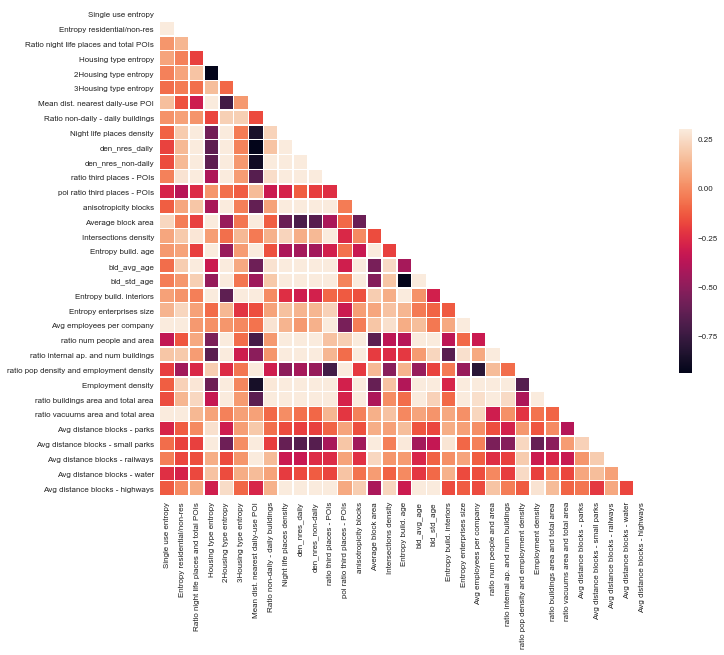

In [75]:
corr = city_df[collist].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=[nomi_sensati[x] for x in corr.columns],
           yticklabels=[nomi_sensati[x] for x in corr.columns])
plt.savefig('figures/matrix_correlation.pdf', format='pdf', dpi=330,bbox_inches='tight')

### All scatters

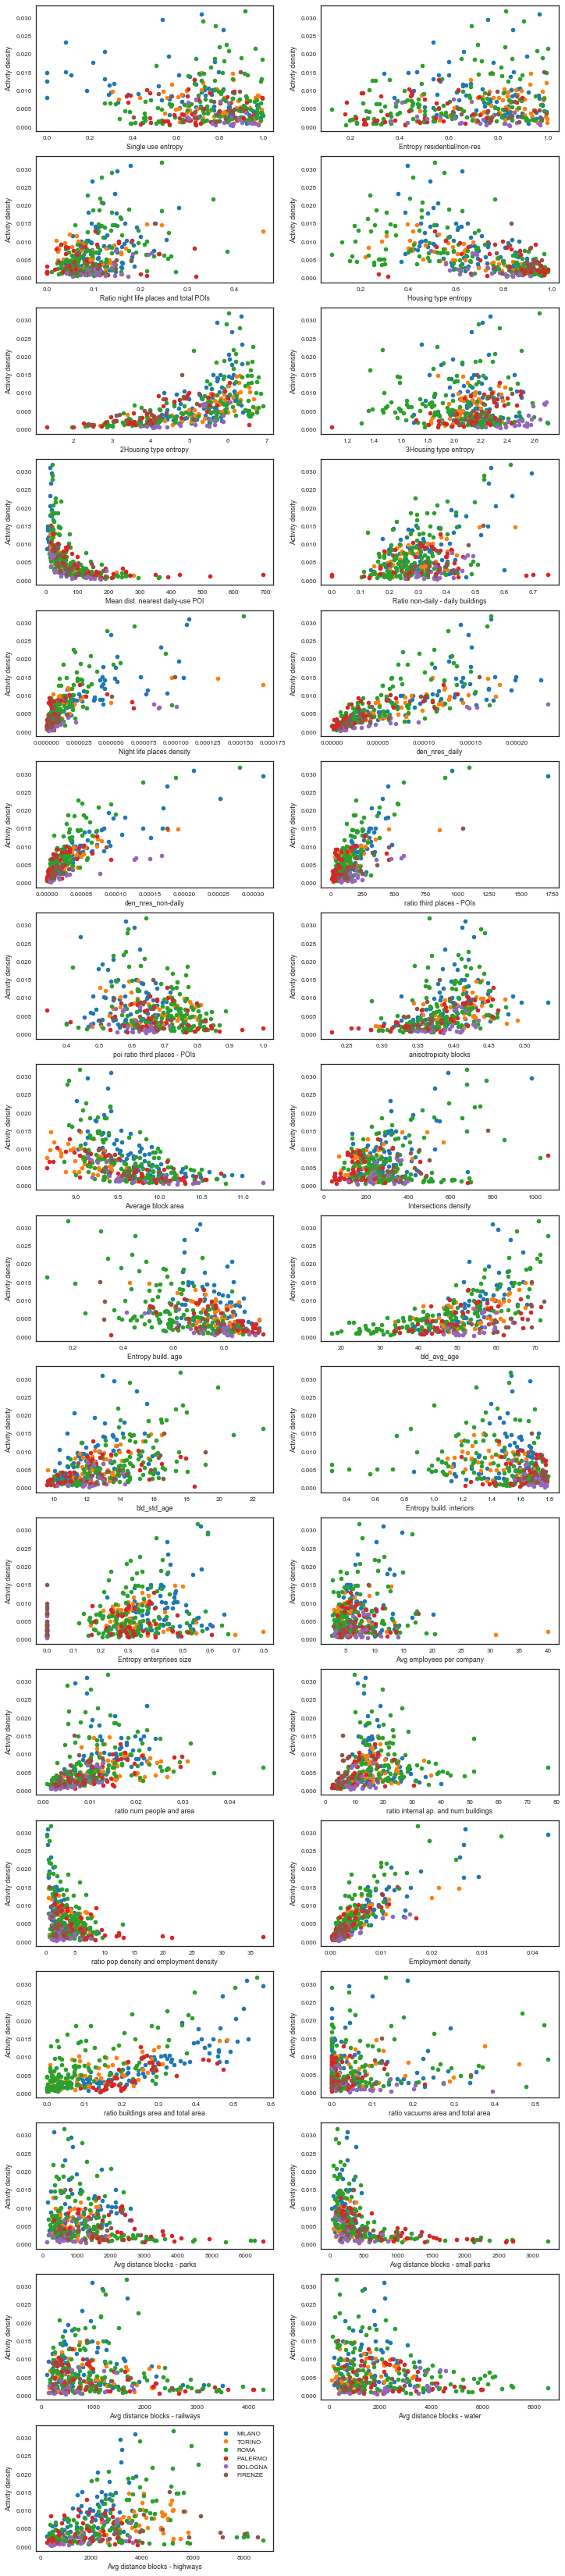

In [77]:
def explain_correlation(attributes_to_plot):
    toPlot = ['activity_density']
    nrows = len(attributes_to_plot)//2+1
    ncols = 2
    fig = plt.figure(figsize=(12,60))
    counter = 0
    for attp in attributes_to_plot:
        for p in toPlot:
            ax = fig.add_subplot(nrows, ncols, counter+1)
            for k,v in CITIES.items():
                ax.plot(city_df[city_df.pro_com == v].sort_values(['pro_com','ace'])[attp], telco_df[telco_df.pro_com == v].sort_values(['pro_com','ace'])[p], 'o', label=k)
            ax.set_ylabel(nomi_sensati[p])
            ax.set_xlabel(nomi_sensati[attp])
            counter += 1
    
    plt.legend()
    
explain_correlation(collist)

## Write distribution plots

LUM5_single 0.733455233143045
RNR_nres 0.6701832670584759
nig_rat_daily 0.10559475696015667


/data/nadai/compiled/python3.6.4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


hType_mix 0.6894636693350972
hType_mix2 4.982309183862059
hType_mix3 2.120196693456203
mdist_nres_daily 76.52883715309112
ratio_daily_nondaily 0.30662088109751867
nig_rat_daily3 1.5816960066906606e-05
den_nres_daily 5.709220924163353e-05
den_nres_non-daily 3.0687098559197465e-05
num_community_places 160.91978609625667
num_community_places_poi 0.6630270374490881
sphi 0.3856314050327995
avg_block_area 9.618463508728182
num_intersect 290.4438502673797
bld_entr_age 0.7109270897170575
bld_avg_age 50.345511547979406
bld_std_age 12.960223750664305
bld_entr_interiors 1.5123447547260775
enterprises_entr_size 0.3092814512716471


/data/nadai/compiled/python3.6.4/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


enterprises_empl_size 6.987746968562273
pop_rat_num 0.011075876837869142
bld_rat_int 15.311171069518718
emp_rat_pop 3.729447639286623
emp_rat_num 0.005019332936930443
bor_rat_area 0.06276657969767711
mdist_parks 1248.0785655193397
mdist_smallparks 456.4047362482866
mdist_railways 1024.275543699171
mdist_water 1965.3429952745857
mdist_highways 2563.5799697756897


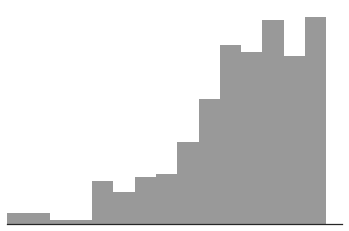

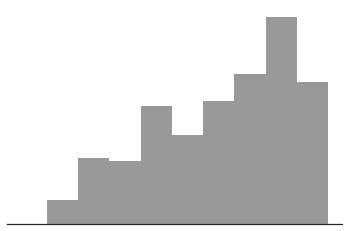

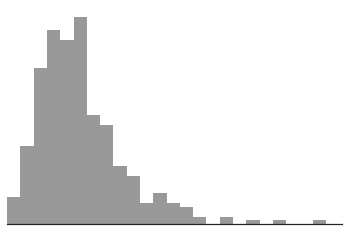

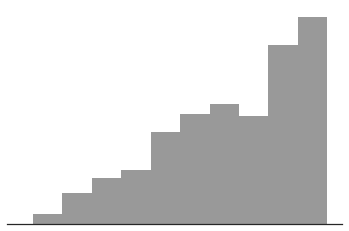

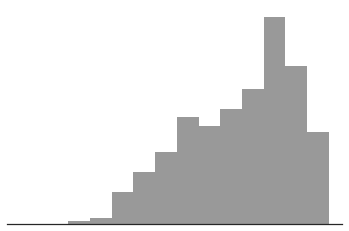

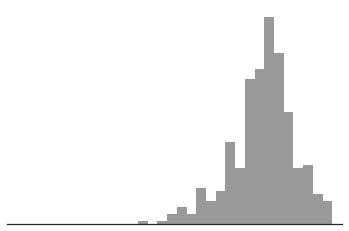

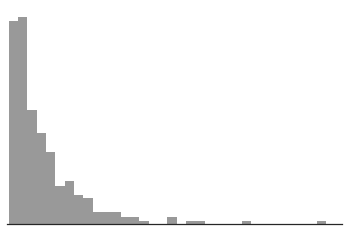

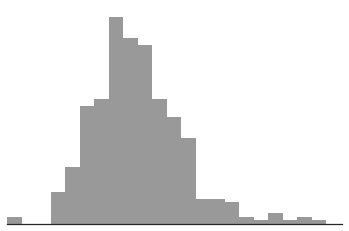

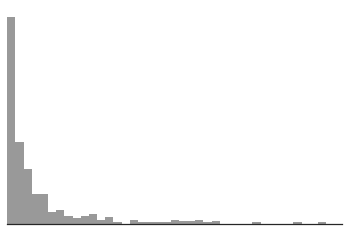

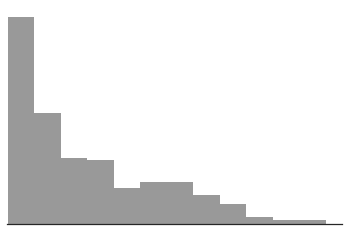

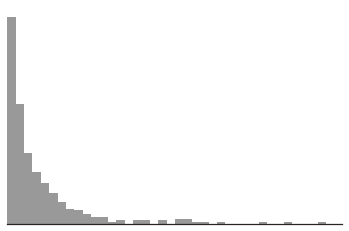

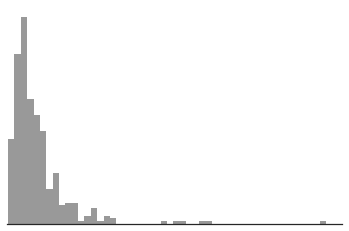

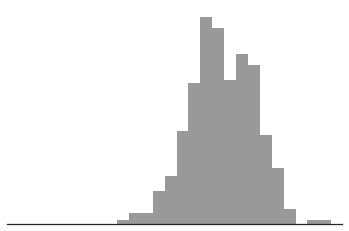

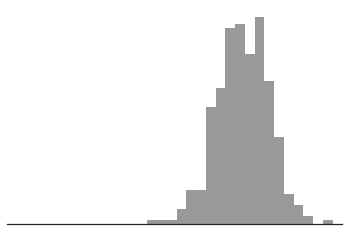

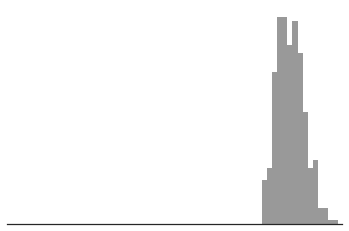

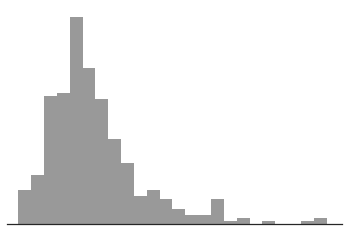

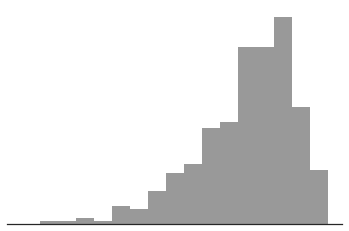

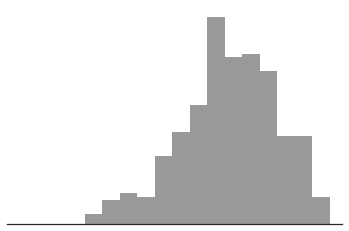

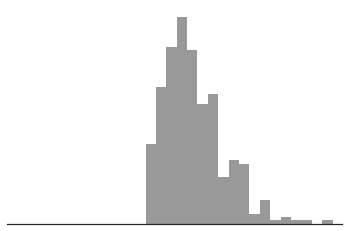

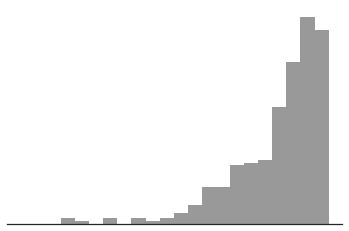

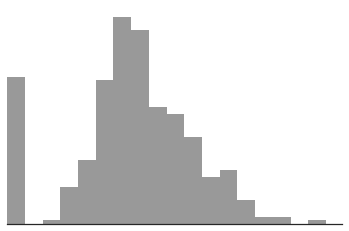

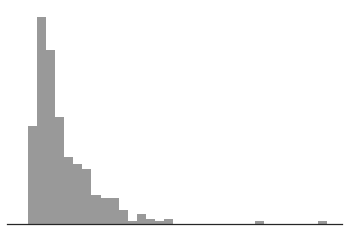

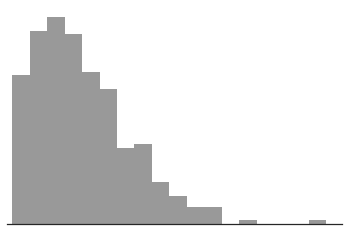

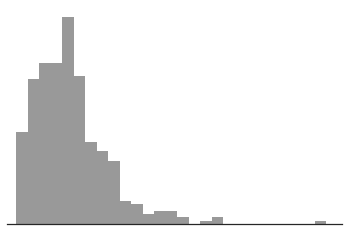

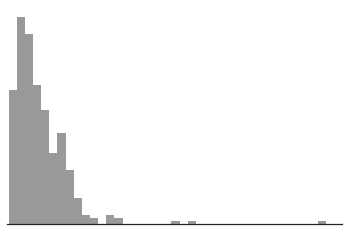

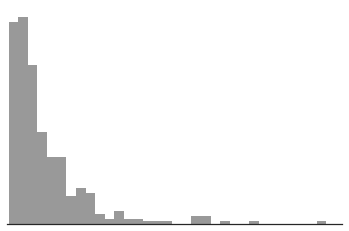

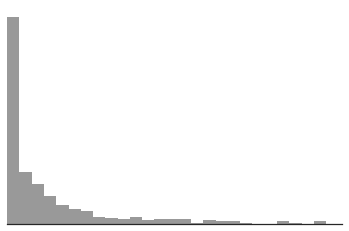

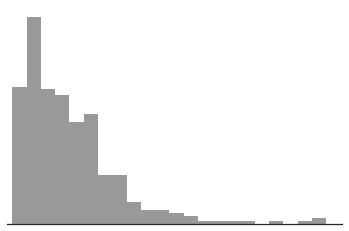

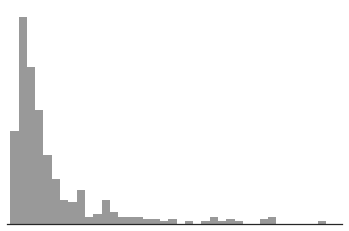

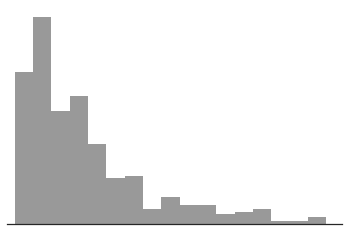

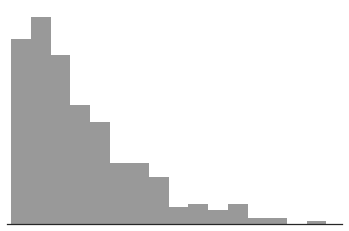

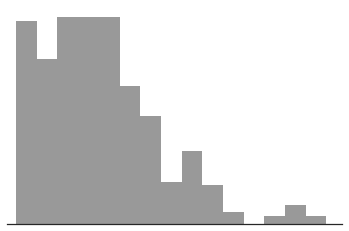

In [82]:
for attr in city_df.columns:
    if attr not in {"bld_rat_area", "ace", "pro_com", "nig_rat_daily2", "reddit4", "rat_block_area", "area", "area_filtr"}:
        plt.figure() #figsize=[fig_width*0.28,0.12]
        print(attr, city_df[attr].mean())
        sns.distplot(city_df[attr], kde=False, color="black")
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("")
        sns.despine(left=True)
        x1,x2,y1,y2 = plt.axis()
        plt.axis([0, x2, y1, y2])
        plt.savefig('figures/paper_distributions/'+attr+".pdf", format='pdf', dpi=330,bbox_inches='tight', pad_inches=0)

## Write dataset

In [81]:
final_df = pd.merge(city_df, telco_df[['pro_com', 'ace', 'activity_density']], on=['ace', 'pro_com'])
final_df.head()

,ace,pro_com,LUM5_single,RNR_nres,nig_rat_daily,hType_mix,hType_mix2,hType_mix3,mdist_nres_daily,ratio_daily_nondaily,...,emp_rat_pop,emp_rat_num,bld_rat_area,bor_rat_area,mdist_parks,mdist_smallparks,mdist_railways,mdist_water,mdist_highways,activity_density
0,1,82053,0.834913,0.720798,0.314583,0.907508,4.370384,2.322173,25.988807,0.377500,...,1.437335,0.007092,0.455101,0.000000,1945.604863,221.193580,920.011375,1368.702528,2824.749650,0.008260
1,5,82053,0.997769,0.896482,0.020000,0.831259,4.737226,2.303030,54.760342,0.181818,...,1.963687,0.004797,0.298615,0.131742,2424.571583,436.532829,299.307165,604.726985,2037.927785,0.008072
2,6,82053,0.671734,0.695502,0.111111,0.899967,4.065773,2.239130,101.339152,0.166667,...,6.091624,0.002088,0.234750,0.003436,3526.516135,405.696049,428.644805,911.581690,1339.969963,0.003594
3,7,82053,0.558117,0.577314,0.000000,0.970021,3.403636,1.941176,100.401111,0.000000,...,19.883005,0.000743,0.198219,0.000000,4915.361344,959.766201,846.295364,1125.378636,1173.661382,0.001571
4,8,82053,0.613831,0.499160,0.100000,0.964111,3.434889,2.130872,253.662195,0.285714,...,6.295181,0.000897,0.175623,0.226589,3815.484344,1045.965308,190.534664,1629.066907,463.298247,0.002417


In [56]:
final_df.to_csv('generated_files/merged_dataset.csv', index=False)